In [64]:
import pandas as pd
import nltk
from sklearn.svm import SVC
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.probability import FreqDist, ConditionalFreqDist
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import metrics


In [4]:
data = pd.read_csv('C:/Users/embicks/Documents/DOTCE/email_marker/email/data/Input/svm_test.csv')
print(data.head())

                                                body sensitivity
0                                    lets grab lunch    Personal
1               I have a meeting with the ambassador    Official
2        Attached are meeting notes about the report    Official
3                   The ambassador is arriving today    Official
4  We have a lunch date today but my daughter is ...    Personal


In [5]:
#Add new column to dataframe with True if sensitivity == personal
#Edit the column names and truth conditions to match your data
data['personal'] = (data['sensitivity'] == 'Personal')
#Create a vector of class labels
class_labels = data['personal']
#use value_counts() method of series
class_labels.value_counts()

False    5
True     4
Name: personal, dtype: int64

In [6]:
train_df = data.iloc[:5]
test_df = data.iloc[5:]
class_labels_training = list(train_df['personal'])
class_labels_test = list(test_df['personal'])
value_counts = nltk.FreqDist(class_labels_training)
print(test_df)
print(train_df)

                                                body sensitivity  personal
5          Where would you like to go to lunch today    Personal      True
6                     What time is the meeting today    Official     False
7                        There is a report due today    Official     False
8  My son is sick so I will be staying home today...    Personal      True
                                                body sensitivity  personal
0                                    lets grab lunch    Personal      True
1               I have a meeting with the ambassador    Official     False
2        Attached are meeting notes about the report    Official     False
3                   The ambassador is arriving today    Official     False
4  We have a lunch date today but my daughter is ...    Personal      True


In [7]:
snowballStemmer = SnowballStemmer("english", ignore_stopwords=True)
def preprocess(text):
    no_punctuation_text = ''
    if (type(text)== str):
        lower_text = text.lower()
        no_punctuation_text = lower_text.translate({ord(c):'' for c in string.punctuation})
    return no_punctuation_text

def myTokenize(text):
    global snowballStemmer
    tokens = []
    cleaned = preprocess(text)
    tokens = nltk.word_tokenize(cleaned)
    filtered = [w for w in tokens if not w in stopwords.words('english')]
    stemmed = [w for w in map(snowballStemmer.stem, filtered)]
    return stemmed


In [12]:
#define vocabulary
vocabulary = ['lunch', 'today', 'sick', 'meeting', 'time', 'home', 'ambassador']

In [13]:
##Instantiate a TFidf vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, encoding='utf-8', 
                             max_df=0.5, tokenizer=myTokenize, vocabulary = vocabulary)
train_X = vectorizer.fit_transform(train_df['body'])
feature_names = vectorizer.get_feature_names()
idf = vectorizer.idf_
word_weight_dict = dict(zip(vectorizer.get_feature_names(), idf))
print(word_weight_dict)

{'lunch': 1.6931471805599454, 'today': 1.6931471805599454, 'sick': 2.09861228866811, 'meeting': 2.791759469228055, 'time': 2.791759469228055, 'home': 2.791759469228055, 'ambassador': 1.6931471805599454}


In [14]:
#train svm model
model_svm = SVC(kernel = 'linear', probability=True)
model_svm.fit(train_X, class_labels_training)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [82]:
#get predictions from svm model
test_X = vectorizer.fit_transform(test_df['body'])
test_word_weight_dict = dict(zip(vectorizer.get_feature_names(), idf))
predictions = model_svm.predict( test_X )
predict_probs = model_svm.predict_proba(test_X)
print(predictions)


print(metrics.classification_report(class_labels_test, predictions))


[ True False False False]
             precision    recall  f1-score   support

      False       0.67      1.00      0.80         2
       True       1.00      0.50      0.67         2

avg / total       0.83      0.75      0.73         4



In [31]:
#get feature coefficients from model
coef = model_svm.coef_.toarray()
top_coefficients = sorted(zip(coef[0], feature_names))
coefficient_dict = {}
for coef, word in top_coefficients:
    coefficient_dict[word] = coef
print(coefficient_dict)    


{'ambassador': -0.65203996377860873, 'today': -0.12026771005052994, 'home': 0.0, 'meeting': 0.0, 'time': 0.0, 'sick': 0.65911800182510549, 'lunch': 1.4538960137130488}


In [85]:
#manually calculate predictions from tfidf scores and model coefficients
predictions = []
for i, row in test_df.iterrows():
    predict_val = 0
    message = row['body']
    text= myTokenize(message)
    for word in text:
        try:
            model_coef = coefficient_dict[word]
            tfidf_score = word_weight_dict[word]
            word_score = model_coef*tfidf_score
            predict_val += word_score
        except:
            predict_val += 0
    if predict_val >0 :
        prediction = True
    else:
        prediction = False
    predictions.append(prediction)
print(predictions)
print(model_svm.intercept_)
print(metrics.classification_report(class_labels_test, predictions))
    

[True, False, False, True]
[ 2.57647332]
             precision    recall  f1-score   support

      False       1.00      1.00      1.00         2
       True       1.00      1.00      1.00         2

avg / total       1.00      1.00      1.00         4



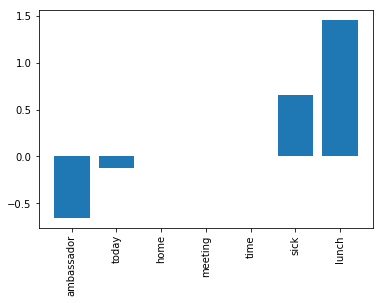

In [86]:
#plot most informative features

plt.bar(range(len(coefficient_dict)), list(coefficient_dict.values()), align='center')
plt.xticks(range(len(coefficient_dict)), list(coefficient_dict.keys()), rotation = '90')
plt.show()